#Fábrica de Cookie

In [114]:
!pip install simpy
import simpy
import numpy as np
import random

In [115]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    RED = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

TEMPO_SIMULACAO = 50

#Tempo de preparo universal


In [116]:
def tempo_preparo_criacao():
  tempo_preparo = np.random.normal(loc=5, scale=1.2)
  tempo_preparo = max(1, tempo_preparo)
  return tempo_preparo

#Arquitetura 1 - fila única e múltiplos Fornos

In [117]:
fornos_status = [False, False, False, False]  # False = livre

def pegar_forno_livre():
    for i, ocupado in enumerate(fornos_status):
        if not ocupado:
            fornos_status[i] = True
            return i
    return None

def liberar_forno(i):
    fornos_status[i] = False


def processar_cookie_1(env, fornos, nome_do_lote, tempo_de_preparo):
    # tempo antes de chegar ao forno
    yield env.timeout(tempo_de_preparo)

    # verifica se vai entrar na fila
    if fornos.count == fornos.capacity:
        print(f"{bcolors.WARNING}[{env.now:3.3f}] Lote {nome_do_lote} entrou na FILA (todos os fornos ocupados){bcolors.ENDC}")
    else:
        print(f"{bcolors.OKCYAN}[{env.now:3.3f}] Lote {nome_do_lote} chegou e há forno LIVRE{bcolors.ENDC}")

    # requisita um dos fornos (fila única)
    req = fornos.request()
    yield req

    # micro-delay para impedir race condition
    yield env.timeout(1e-6)

    # escolhe o forno correto
    forno_id = pegar_forno_livre()

    print(f"[{env.now:3.3f}] Lote {nome_do_lote} entrou no FORNO {forno_id}")

    # tempo dentro do forno
    yield env.timeout(tempo_de_preparo)

    print(f"{bcolors.OKGREEN}[{env.now:3.3f}] 🍪 Lote {nome_do_lote} saiu do FORNO {forno_id}{bcolors.ENDC}")

    # libera forno e o recurso
    liberar_forno(forno_id)
    fornos.release(req)


In [118]:
def gerar_lotes_1(env, fornos):
    lote_id = 0
    media_intervalo_chegada = 2.5
    lambd = 1.0 / media_intervalo_chegada

    while True:
        lote_id += 1
        tempo_preparo = tempo_preparo_criacao()
        env.process(processar_cookie_1(env, fornos, f"L{lote_id}", tempo_preparo))
        yield env.timeout(random.expovariate(lambd))

In [119]:
env = simpy.Environment()

# 4 FORNOS
fornos = simpy.Resource(env, capacity=4)

env.process(gerar_lotes_1(env, fornos))
env.run(until=TEMPO_SIMULACAO)

[2.869] Lote L1 chegou e há forno LIVRE
[2.869] Lote L1 entrou no FORNO 0
[5.738] 🍪 Lote L1 saiu do FORNO 0
[11.829] Lote L2 chegou e há forno LIVRE
[11.829] Lote L2 entrou no FORNO 0
[15.533] Lote L3 chegou e há forno LIVRE
[15.533] Lote L3 entrou no FORNO 1
[16.013] Lote L4 chegou e há forno LIVRE
[16.013] Lote L4 entrou no FORNO 2
[16.425] Lote L5 chegou e há forno LIVRE
[16.425] Lote L5 entrou no FORNO 3
[18.384] 🍪 Lote L2 saiu do FORNO 0
[19.853] Lote L6 chegou e há forno LIVRE
[19.853] Lote L6 entrou no FORNO 0
[21.337] 🍪 Lote L3 saiu do FORNO 1
[21.378] 🍪 Lote L4 saiu do FORNO 2
[22.054] 🍪 Lote L5 saiu do FORNO 3
[23.649] 🍪 Lote L6 saiu do FORNO 0
[28.581] Lote L7 chegou e há forno LIVRE
[28.581] Lote L7 entrou no FORNO 0
[29.490] Lote L8 chegou e há forno LIVRE
[29.490] Lote L8 entrou no FORNO 1
[30.186] Lote L10 chegou e há forno LIVRE
[30.186] Lote L10 entrou no FORNO 2
[30.590] Lote L9 chegou e há forno LIVRE
[30.590] Lote L9 entrou no FORNO 3
[33.764] 🍪 Lote L7 saiu do FORN

# Arquitetura 2 - múltiplas filas, múltiplos fornos.

In [120]:
def processar_cookie_2(env, forno, nome_do_lote, tempo_de_preparo, forno_id):
    # tempo antes de chegar ao forno
    yield env.timeout(tempo_de_preparo)

    # se o forno estiver ocupado → fila
    if forno.count == forno.capacity:
        print(f"{bcolors.WARNING}[{env.now:3.3f}] Lote {nome_do_lote} ENTROU na FILA do forno {forno_id}{bcolors.ENDC}")
    else:
        print(f"{bcolors.OKCYAN}[{env.now:3.3f}] Lote {nome_do_lote} chegou e o forno {forno_id} está LIVRE{bcolors.ENDC}")

    req = forno.request()
    yield req

    print(f"[{env.now:3.3f}] Lote {nome_do_lote} entrou no FORNO {forno_id}")

    yield env.timeout(tempo_de_preparo)

    print(f"{bcolors.OKGREEN}[{env.now:3.3f}] 🍪 Lote {nome_do_lote} saiu do FORNO {forno_id}{bcolors.ENDC}")

    forno.release(req)


In [121]:
def gerar_lotes_2(env, fornos):
    lote_id = 0
    media_intervalo_chegada = 2.5
    lambd = 1.0 / media_intervalo_chegada

    while True:
        lote_id += 1
        tempo_preparo = tempo_preparo_criacao()

        # escolha do forno (menor fila)
        filas = [f.queue for f in fornos]
        forno_escolhido = min(range(len(fornos)), key=lambda i: len(filas[i]))


        env.process(
            processar_cookie_2(
                env,
                fornos[forno_escolhido],
                f"L{lote_id}",
                tempo_preparo,
                forno_escolhido
            )
        )

        # APLICAÇÃO DA DISTRIBUIÇÃO PROBABILÍSTICA (EXPONENCIAL)
        yield env.timeout(random.expovariate(lambd))

In [122]:
env = simpy.Environment()

# 4 fornos → 4 filas distintas
fornos = [simpy.Resource(env, capacity=1) for _ in range(4)]

env.process(gerar_lotes_2(env, fornos))

env.run(until=50)


[4.347] Lote L1 chegou e o forno 0 está LIVRE
[4.347] Lote L1 entrou no FORNO 0
[5.259] Lote L2 ENTROU na FILA do forno 0
[8.693] 🍪 Lote L1 saiu do FORNO 0
[8.693] Lote L2 entrou no FORNO 0
[13.018] 🍪 Lote L2 saiu do FORNO 0
[19.343] Lote L3 chegou e o forno 0 está LIVRE
[19.343] Lote L3 entrou no FORNO 0
[20.361] Lote L4 ENTROU na FILA do forno 0
[21.604] Lote L5 ENTROU na FILA do forno 0
[24.181] Lote L7 chegou e o forno 1 está LIVRE
[24.181] Lote L7 entrou no FORNO 1
[24.431] 🍪 Lote L3 saiu do FORNO 0
[24.431] Lote L4 entrou no FORNO 0
[24.566] Lote L8 ENTROU na FILA do forno 1
[25.604] Lote L6 ENTROU na FILA do forno 0
[27.845] Lote L9 ENTROU na FILA do forno 1
[27.897] 🍪 Lote L7 saiu do FORNO 1
[27.897] Lote L8 entrou no FORNO 1
[27.912] 🍪 Lote L4 saiu do FORNO 0
[27.912] Lote L5 entrou no FORNO 0
[29.665] Lote L13 chegou e o forno 2 está LIVRE
[29.665] Lote L13 entrou no FORNO 2
[29.936] Lote L11 ENTROU na FILA do forno 2
[30.171] Lote L10 ENTROU na FILA do forno 1
[31.196] 🍪 Lot

# Arquitetura 3 - múltiplas filas e um forno

In [123]:
def processar_cookie_3(env, forno, nome_do_lote, tempo_de_preparo, forno_id):
    # tempo forno
    yield env.timeout(tempo_de_preparo)

    # se o forno estiver ocupado → fila
    if forno.count == forno.capacity:
        print(f"{bcolors.WARNING}[{env.now:3.3f}] Lote {nome_do_lote} ENTROU na FILA do forno {forno_id}{bcolors.ENDC}")
    else:
        print(f"{bcolors.OKCYAN}[{env.now:3.3f}] Lote {nome_do_lote} chegou e o forno {forno_id} está LIVRE{bcolors.ENDC}")

    req = forno.request()
    yield req

    print(f"[{env.now:3.3f}] Lote {nome_do_lote} entrou no FORNO {forno_id}")

    yield env.timeout(tempo_de_preparo)

    print(f"{bcolors.OKGREEN}[{env.now:3.3f}] 🍪 Lote {nome_do_lote} saiu do FORNO {forno_id}{bcolors.ENDC}")

    forno.release(req)


In [124]:
def gerar_lotes_3(env, fornos):
    lote_id = 0

    media_intervalo_chegada = 2.5
    lambd = 1.0 / media_intervalo_chegada

    while True:
        lote_id += 1
        tempo_preparo =  tempo_preparo_criacao()

        env.process(
            processar_cookie_3(
                env,
                fornos[0],
                f"L{lote_id}",
                tempo_preparo,
                0
            )
        )

        # APLICAÇÃO DA DISTRIBUIÇÃO PROBABILÍSTICA (EXPONENCIAL)
        yield env.timeout(random.expovariate(lambd))


In [125]:
env = simpy.Environment()

# 1 fornos
fornos = [simpy.Resource(env, capacity=1) for _ in range(1)]

env.process(gerar_lotes_3(env, fornos))

env.run(until=50)


[4.650] Lote L1 chegou e o forno 0 está LIVRE
[4.650] Lote L1 entrou no FORNO 0
[6.932] Lote L2 ENTROU na FILA do forno 0
[9.299] 🍪 Lote L1 saiu do FORNO 0
[9.299] Lote L2 entrou no FORNO 0
[9.852] Lote L3 ENTROU na FILA do forno 0
[13.628] Lote L4 ENTROU na FILA do forno 0
[14.115] 🍪 Lote L2 saiu do FORNO 0
[14.115] Lote L3 entrou no FORNO 0
[16.919] Lote L6 ENTROU na FILA do forno 0
[17.117] Lote L5 ENTROU na FILA do forno 0
[17.952] Lote L7 ENTROU na FILA do forno 0
[19.793] Lote L8 ENTROU na FILA do forno 0
[20.251] 🍪 Lote L3 saiu do FORNO 0
[20.251] Lote L4 entrou no FORNO 0
[21.205] Lote L9 ENTROU na FILA do forno 0
[21.724] Lote L10 ENTROU na FILA do forno 0
[25.147] Lote L11 ENTROU na FILA do forno 0
[26.325] 🍪 Lote L4 saiu do FORNO 0
[26.325] Lote L6 entrou no FORNO 0
[27.856] Lote L12 ENTROU na FILA do forno 0
[31.042] 🍪 Lote L6 saiu do FORNO 0
[31.042] Lote L5 entrou no FORNO 0
[36.486] 🍪 Lote L5 saiu do FORNO 0
[36.486] Lote L7 entrou no FORNO 0
[36.679] Lote L13 ENTROU na 

#Integração — Arquitetura 3 (múltiplas filas, um forno)

In [126]:
%%bash
cat > metricas.py <<'PY'
import matplotlib.pyplot as plt
import pandas as pd

class MetricasSimulacao:
    def __init__(self, nome_arquitetura):
        self.nome = nome_arquitetura
        self.eventos = []

    def registrar_evento(self, lote, chegada, entrada, saida, forno_id):
        self.eventos.append({
            "lote": lote,
            "chegada": chegada,
            "entrada_forno": entrada,
            "saida": saida,
            "forno": forno_id
        })

    def resumo(self, tempo_total):
        df = pd.DataFrame(self.eventos)
        if df.empty:
            print("Nenhum evento registrado!")
            return None

        df["tempo_fila"] = df["entrada_forno"] - df["chegada"]
        df["tempo_sistema"] = df["saida"] - df["chegada"]

        print(f"\n📊 --- Métricas: {self.nome} ---")
        print(f"Total de lotes processados: {len(df)}")
        print(f"Tempo médio na fila: {df['tempo_fila'].mean():.2f}")
        print(f"Tempo médio no sistema: {df['tempo_sistema'].mean():.2f}")
        print(f"Throughput (lotes/min): {len(df) / tempo_total:.3f}")

        utilizacao = df.groupby("forno")["tempo_sistema"].sum() / tempo_total
        utilizacao = (utilizacao * 100).round(1)
        print(f"Utilização dos fornos (%): {list(utilizacao)}")

        return df

    def plotar_graficos(self):
        df = pd.DataFrame(self.eventos)
        if df.empty:
            return
        df["tempo_fila"] = df["entrada_forno"] - df["chegada"]
        df["tempo_sistema"] = df["saida"] - df["chegada"]

        plt.figure(figsize=(10, 5))
        plt.plot(df["lote"], df["tempo_fila"], label="Tempo na Fila")
        plt.plot(df["lote"], df["tempo_sistema"], label="Tempo no Sistema")
        plt.title(f"Tempos - {self.nome}")
        plt.xlabel("Lote")
        plt.ylabel("Tempo (min)")
        plt.legend()
        plt.grid(True)
        plt.show()
PY


In [127]:
import simpy, random
from metricas import MetricasSimulacao

TEMPO_SIMULACAO = 100
random.seed(42)



📊 --- Métricas: Arquitetura 1 - Fila Única, Múltiplos Fornos ---
Total de lotes processados: 38
Tempo médio na fila: 5.47
Tempo médio no sistema: 10.84
Throughput (lotes/min): 0.380
Utilização dos fornos (%): [150.0, 113.0, 102.0, 47.0]


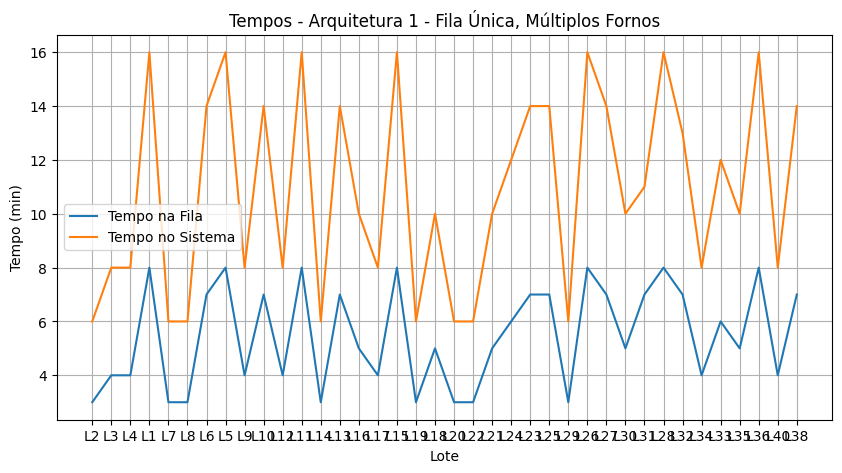

In [128]:
# === Arquitetura 1 ===
metricas1 = MetricasSimulacao("Arquitetura 1 - Fila Única, Múltiplos Fornos")

fornos_status = [False, False, False, False]
def pegar_forno_livre():
    for i, ocupado in enumerate(fornos_status):
        if not ocupado:
            fornos_status[i] = True
            return i
    return None
def liberar_forno(i): fornos_status[i] = False

def processar_cookie_1(env, fornos, nome_do_lote, tempo_de_preparo):
    chegada = env.now
    yield env.timeout(tempo_de_preparo)
    req = fornos.request()
    yield req
    forno_id = pegar_forno_livre()
    entrada = env.now
    yield env.timeout(tempo_de_preparo)
    saida = env.now
    liberar_forno(forno_id)
    fornos.release(req)
    metricas1.registrar_evento(nome_do_lote, chegada, entrada, saida, forno_id)

def gerar_lotes_1(env, fornos):
    lote_id = 0
    while True:
        lote_id += 1
        tempo_preparo = random.randint(3, 8)
        env.process(processar_cookie_1(env, fornos, f"L{lote_id}", tempo_preparo))
        yield env.timeout(random.randint(1, 4))

env = simpy.Environment()
fornos = simpy.Resource(env, capacity=4)
env.process(gerar_lotes_1(env, fornos))
env.run(until=TEMPO_SIMULACAO)
df1 = metricas1.resumo(TEMPO_SIMULACAO)
metricas1.plotar_graficos()



📊 --- Métricas: Arquitetura 2 - Múltiplas Filas, Múltiplos Fornos ---
Total de lotes processados: 30
Tempo médio na fila: 9.23
Tempo médio no sistema: 15.03
Throughput (lotes/min): 0.300
Utilização dos fornos (%): [201.0, 159.0, 91.0]


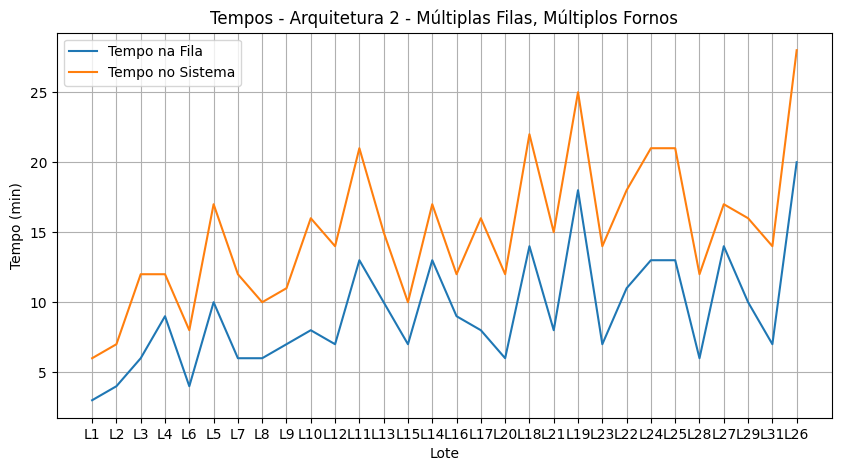

In [129]:
# === Arquitetura 2 ===
metricas2 = MetricasSimulacao("Arquitetura 2 - Múltiplas Filas, Múltiplos Fornos")

def processar_cookie_2(env, forno, nome_do_lote, tempo_de_preparo, forno_id):
    chegada = env.now
    yield env.timeout(tempo_de_preparo)
    req = forno.request()
    yield req
    entrada = env.now
    yield env.timeout(tempo_de_preparo)
    saida = env.now
    forno.release(req)
    metricas2.registrar_evento(nome_do_lote, chegada, entrada, saida, forno_id)

def gerar_lotes_2(env, fornos):
    lote_id = 0
    while True:
        lote_id += 1
        tempo_preparo = random.randint(3, 8)
        filas = [f.queue for f in fornos]
        forno_escolhido = min(range(len(fornos)), key=lambda i: len(filas[i]))
        env.process(processar_cookie_2(env, fornos[forno_escolhido], f"L{lote_id}", tempo_preparo, forno_escolhido))
        yield env.timeout(random.randint(1, 4))

env = simpy.Environment()
fornos = [simpy.Resource(env, capacity=1) for _ in range(4)]
env.process(gerar_lotes_2(env, fornos))
env.run(until=TEMPO_SIMULACAO)
df2 = metricas2.resumo(TEMPO_SIMULACAO)
metricas2.plotar_graficos()



📊 --- Métricas: Arquitetura 3 - Múltiplas Filas, Um Forno ---
Total de lotes processados: 19
Tempo médio na fila: 25.79
Tempo médio no sistema: 30.74
Throughput (lotes/min): 0.190
Utilização dos fornos (%): [584.0]


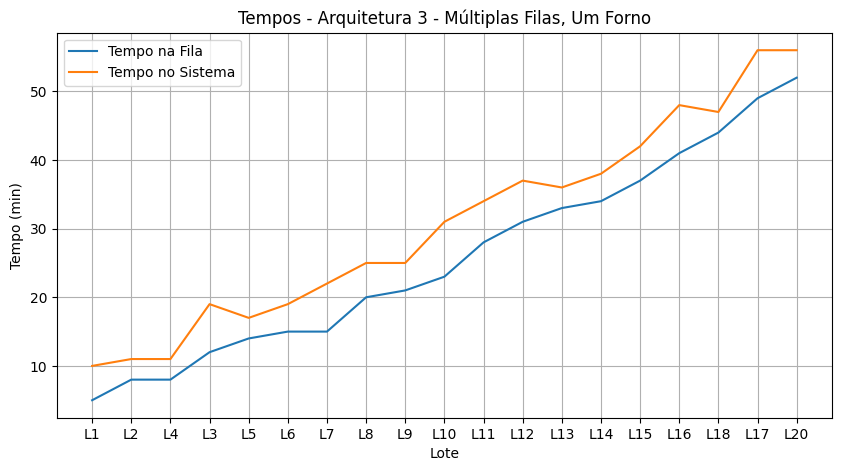

In [130]:
# === Arquitetura 3 ===
metricas3 = MetricasSimulacao("Arquitetura 3 - Múltiplas Filas, Um Forno")

def processar_cookie_3(env, forno, nome_do_lote, tempo_de_preparo, forno_id):
    chegada = env.now
    yield env.timeout(tempo_de_preparo)
    req = forno.request()
    yield req
    entrada = env.now
    yield env.timeout(tempo_de_preparo)
    saida = env.now
    forno.release(req)
    metricas3.registrar_evento(nome_do_lote, chegada, entrada, saida, forno_id)

def gerar_lotes_3(env, fornos):
    lote_id = 0
    while True:
        lote_id += 1
        tempo_preparo = random.randint(3, 8)
        env.process(processar_cookie_3(env, fornos[0], f"L{lote_id}", tempo_preparo, 0))
        yield env.timeout(random.randint(1, 4))

env = simpy.Environment()
fornos = [simpy.Resource(env, capacity=1)]
env.process(gerar_lotes_3(env, fornos))
env.run(until=TEMPO_SIMULACAO)
df3 = metricas3.resumo(TEMPO_SIMULACAO)
metricas3.plotar_graficos()



🏁 Comparação de desempenho (tempo médio no sistema):
Arquitetura 1: 10.84
Arquitetura 2: 15.03
Arquitetura 3: 30.74

✅ Melhor arquitetura (menor tempo no sistema): Arquitetura 1


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128081 (\N{CROWN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


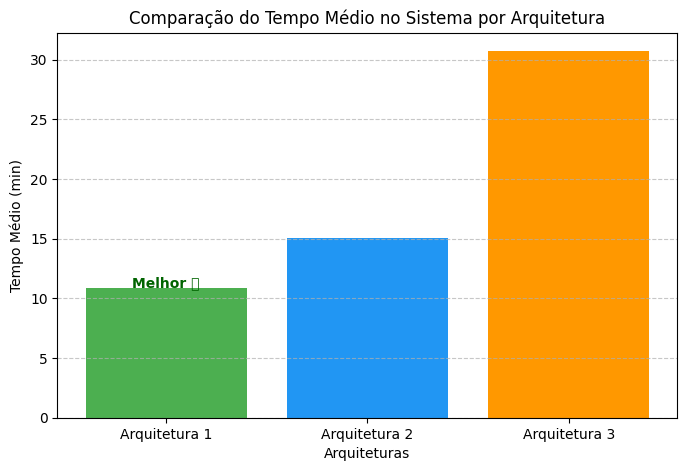

In [131]:
# Comparar médias
comparacao = {
    "Arquitetura 1": df1["tempo_sistema"].mean(),
    "Arquitetura 2": df2["tempo_sistema"].mean(),
    "Arquitetura 3": df3["tempo_sistema"].mean(),
}

print("\n🏁 Comparação de desempenho (tempo médio no sistema):")
for k, v in comparacao.items():
    print(f"{k}: {v:.2f}")

melhor = min(comparacao, key=comparacao.get)
print(f"\n✅ Melhor arquitetura (menor tempo no sistema): {melhor}")

# ====== Gráfico comparativo ======
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(comparacao.keys(), comparacao.values(), color=["#4CAF50", "#2196F3", "#FF9800"])
plt.title("Comparação do Tempo Médio no Sistema por Arquitetura")
plt.ylabel("Tempo Médio (min)")
plt.xlabel("Arquiteturas")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Destacar a melhor arquitetura
ymax = max(comparacao.values())
plt.text(melhor, comparacao[melhor] + 0.1, "Melhor 👑", ha="center", color="darkgreen", fontweight="bold")

plt.show()


# Lista global para armazenar estatísticas

In [132]:
# Lista global para armazenar estatísticas
dados_simulacao = []

def processar_cookie_com_metricas(env, fornos, id_lote, tempo_preparo):
    chegada = env.now

    # Requisita o forno
    req = fornos.request()
    yield req

    # Momento que entrou no forno (saiu da fila)
    inicio_servico = env.now
    tempo_espera = inicio_servico - chegada

    # Processamento
    yield env.timeout(tempo_preparo)

    saida = env.now
    tempo_sistema = saida - chegada

    fornos.release(req)

    # Registra os dados
    dados_simulacao.append({
        "id": id_lote,
        "espera_na_fila": tempo_espera,
        "tempo_servico": tempo_preparo,
        "tempo_total": tempo_sistema
    })

def gerar_lotes(env, fornos):
    i = 0
    while True:
        i += 1
        tempo = random.randint(3, 8)
        env.process(processar_cookie_com_metricas(env, fornos, i, tempo))
        yield env.timeout(random.randint(1, 4))

# Rodando
env = simpy.Environment()
fornos = simpy.Resource(env, capacity=4)
env.process(gerar_lotes(env, fornos))
env.run(until=200) # Aumentei o tempo para ter mais amostras

# --- ANÁLISE DOS DADOS ---
esperas = [d['espera_na_fila'] for d in dados_simulacao]
total_processados = len(dados_simulacao)

print("-" * 30)
print(f"Total de Lotes Processados: {total_processados}")
print(f"Tempo Médio em Fila: {np.mean(esperas):.2f} segundos")
print(f"Tempo Máximo em Fila: {np.max(esperas):.2f} segundos")
print("-" * 30)

------------------------------
Total de Lotes Processados: 86
Tempo Médio em Fila: 0.07 segundos
Tempo Máximo em Fila: 2.00 segundos
------------------------------


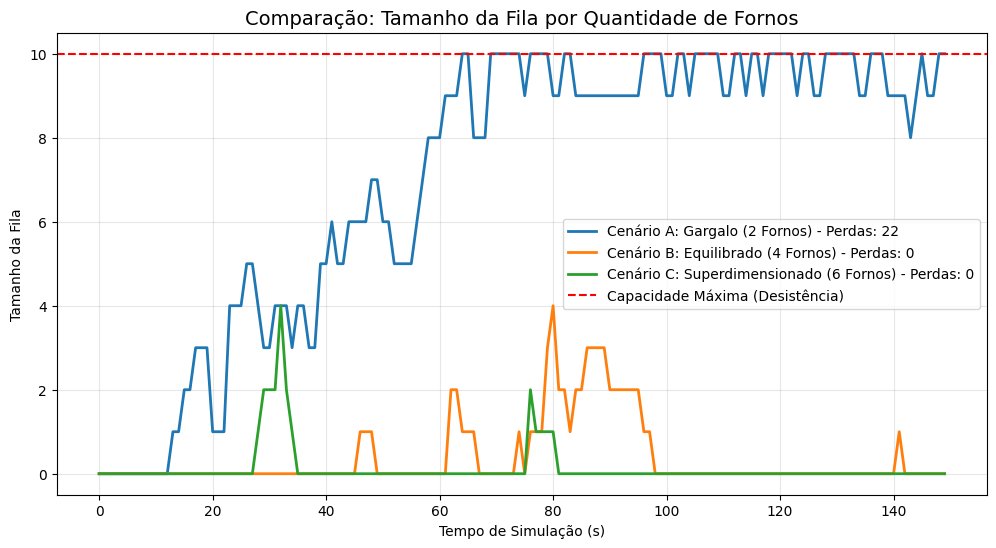

In [134]:


# --- FUNÇÃO DE SIMULAÇÃO CONFIGURÁVEL ---
def rodar_cenario(env_name, num_fornos, media_chegada, media_preparo, capacidade_fila, tempo_simulacao):
    env = simpy.Environment()
    fornos = simpy.Resource(env, capacity=num_fornos)

    # Listas para guardar dados do tempo e tamanho da fila
    registro_tempo = []
    registro_fila = []
    desistencias = 0

    # Processo de Monitoramento (Espião)
    def monitorar():
        while True:
            registro_tempo.append(env.now)
            registro_fila.append(len(fornos.queue))
            yield env.timeout(1) # Coleta a cada 1 segundo

    # Processo de Chegada e Serviço
    def gerar_lotes():
        nonlocal desistencias
        lambd = 1.0 / media_chegada
        while True:
            yield env.timeout(random.expovariate(lambd))

            # Lógica de Desistência
            if len(fornos.queue) >= capacidade_fila:
                desistencias += 1
                continue # Pula para o próximo loop (lote perdido)

            # Processo normal
            env.process(processar(env))

    def processar(env):
        with fornos.request() as req:
            yield req
            # Tempo de serviço Normal (Gaussiana)
            tempo = max(0.5, random.gauss(media_preparo, 1.0))
            yield env.timeout(tempo)

    # Inicia processos
    env.process(gerar_lotes())
    env.process(monitorar())
    env.run(until=tempo_simulacao)

    return registro_tempo, registro_fila, desistencias

# --- DEFINIÇÃO DOS CENÁRIOS PARA COMPARAÇÃO ---
# Vamos testar 3 configurações de fábrica diferentes

cenarios = [
    # (Nome, Fornos, Chegada, Preparo, LimiteFila)
    ("Cenário A: Gargalo (2 Fornos)", 2, 2.5, 8.0, 10),
    ("Cenário B: Equilibrado (4 Fornos)", 4, 2.5, 8.0, 10),
    ("Cenário C: Superdimensionado (6 Fornos)", 6, 2.5, 8.0, 10)
]

tempo_total = 150

# --- PLOTAGEM DOS GRÁFICOS ---
plt.figure(figsize=(12, 6))

for nome, n_fornos, m_chegada, m_preparo, lim_fila in cenarios:
    # Roda a simulação para este cenário
    tempos, filas, perdas = rodar_cenario("Sim", n_fornos, m_chegada, m_preparo, lim_fila, tempo_total)

    # Plota a linha
    plt.plot(tempos, filas, label=f'{nome} - Perdas: {perdas}', linewidth=2)

plt.axhline(y=10, color='r', linestyle='--', label='Capacidade Máxima (Desistência)')
plt.title("Comparação: Tamanho da Fila por Quantidade de Fornos", fontsize=14)
plt.xlabel("Tempo de Simulação (s)")
plt.ylabel("Tamanho da Fila")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()